<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b> DM-47045-Investigate excess diaSources in Cosmos following DM-46678 </b><br>
Notebook comparing main with the updated sourceSelector configs in subtractImages <code>diffIm</code> (DM-46678). The updated configurations caused an excess number of diaSources in the HSC and Cosmos datasets while decreasing the number of diaSources in DECam. <br> <br>

Contact author: Audrey Budlong <br>
Last verified to run: 23 October 2024 <br>
LSST Science Pipelines version: <code>d_2024_10_07</code> <br>
Additional notes: run with a local ap_verfify run of <code>ap_verify_ci_dc2</code> <br>

## Run details

Baseline run using <code>d_2024_10_07</code>. 

### Table of Contents

1. Main package imports
2. Configuring data access
3. APBD Source Comparison
4. Visualizing APDB Source Comparison
5. Source Comparison at Detector-Level

### 1. Main package imports

In [1]:
import lsst.afw.display as afwDisplay
import lsst.geom as geom
import gc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from astropy.table import Table
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
from lsst.afw.image import MultibandExposure
from lsst.analysis.ap import apdb, nb_utils
from lsst.analysis.ap import plotImageSubtractionCutouts as plotISC
from lsst.daf.butler import Butler
from sqlalchemy import select, func

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'whitesmoke'

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 2. Configuring data access

In [2]:
repo_main = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DC2/d_2024_10_07-DM47045-main/repo/butler.yaml'
repo_updated = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DC2/d_2024_10_07-DM47045/repo/butler.yaml'
collections = 'ap_verify-output'
instrument = 'LSSTCam-imSim'
skymap = 'decam_rings_v1'

butler_main = Butler(repo_main, collections=collections)
butler_updated = Butler(repo_updated, collections=collections)

dbType = 'sqlite'
dbName_main = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DC2/d_2024_10_07-DM47045-main/association.db'
dbName_updated = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DC2/d_2024_10_07-DM47045/association.db'

reader_main = apdb.ApdbSqliteQuery(dbName_main, instrument=instrument)
reader_updated = apdb.ApdbSqliteQuery(dbName_updated, instrument=instrument)

In [3]:
len(reader_main._tables), len(reader_updated._tables)

(6, 6)

In [4]:
main_run = {
    'repo': repo_main,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler_main,
    'dbType': dbType,
    'dbName': dbName_main,
    'reader': reader_main
}

updated_run = {
    'repo': repo_updated,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler_updated,
    'dbType': dbType,
    'dbName': dbName_updated,
    'reader': reader_updated
}

In [5]:
main_run['run_name'] = 'Main'
updated_run['run_name'] = 'With DM-42979'

In [6]:
main_run['robjTable'] = main_run['reader'].load_objects()
main_run['rsrcTable'] = main_run['reader'].load_sources()

updated_run['robjTable'] = updated_run['reader'].load_objects()
updated_run['rsrcTable'] = updated_run['reader'].load_sources()

In [7]:
registry_main = butler_main.registry
registry_updated = butler_updated.registry

datarefs_main = list(registry_main.queryDatasets('initial_pvi'))
datarefs_updated = list(registry_updated.queryDatasets('initial_pvi'))

In [8]:
visits = [982985, 943296]
detectors = [164, 168]
visitsAndDetectors = pd.DataFrame({'visits': visits, 'detectors': detectors}).sort_values(by=['visits', 'detectors'])
visitsAndDetectors

,visits,detectors
1,943296,168
0,982985,164


In [9]:
len(datarefs_main), len(datarefs_updated)

(2, 2)

### 3. APBD Source Comparison

In [10]:
selfTest1, selfTest2, selfMatchedTest = nb_utils.compare_sources(repo_main, repo_main, reader_main, reader_main)

276 matched sources; 0 unique to set 1; 0 unique to set 2.


#### Comparing main with DM-46678 updated configurations

In [11]:
uniqueMain, uniqueUpdated, matched = nb_utils.compare_sources(repo_main, repo_updated, reader_main, reader_updated)

204 matched sources; 72 unique to set 1; 104 unique to set 2.


### 4. Visualizing APDB Source Comparison

In [12]:
sns.color_palette("Spectral", 20)

[(0.7211072664359862, 0.11649365628604381, 0.28281430219146486),
 (0.8226066897347175, 0.22906574394463664, 0.30680507497116494),
 (0.8853517877739331, 0.3190311418685121, 0.29042675893886966),
 (0.942560553633218, 0.4057670126874279, 0.2682814302191465),
 (0.9693194925028835, 0.5174163783160323, 0.30426758938869664),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9953094963475586, 0.8399846212995001, 0.5128027681660899),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.9990003844675125, 0.9690119184928874, 0.697039600153787),
 (0.9750096116878124, 0.9900038446751249, 0.7100346020761246),
 (0.9288735101883892, 0.9715494040753557, 0.6380622837370243),
 (0.8565936178392929, 0.942329873125721, 0.6053056516724337),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.6334486735870821, 0.8521337946943485, 0.6436755094194541),
 (0.4955017301038063, 0.7981545559400232, 0.6456747404844291),
 (0.3760092272202999, 0.7340253748558246, 0.6581314878892733),
 (0.2800461361014994, 0.6269896193771626, 0.7024221453287197),
 (0.20622837370242214, 0.5201845444059977, 0.7349480968858132),
 (0.2874279123414072, 0.4149942329873126, 0.6851211072664359)]

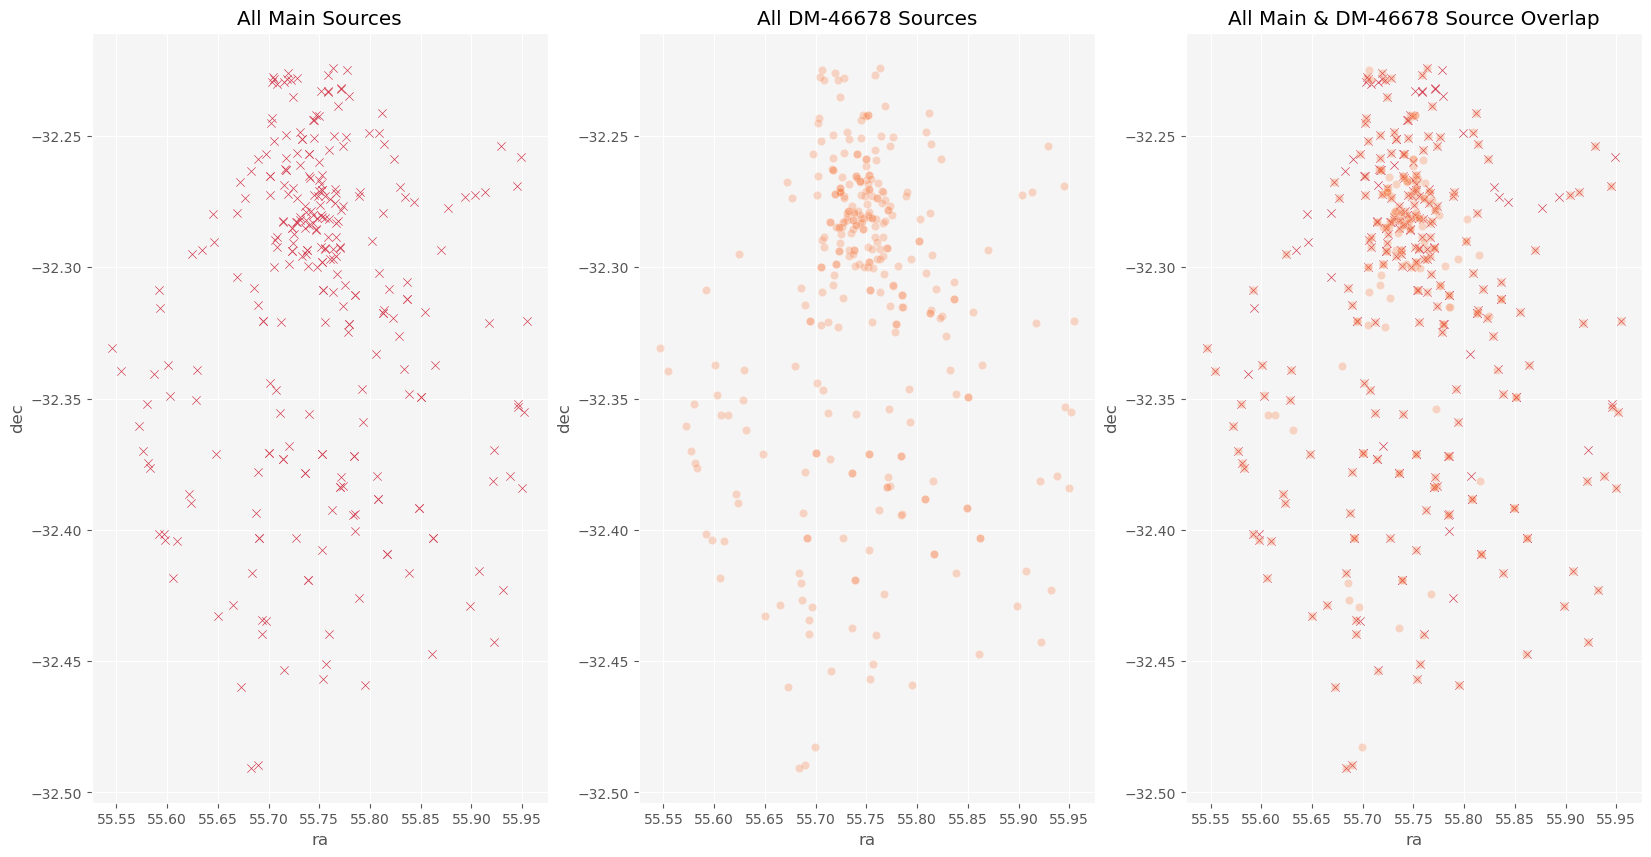

In [13]:
# Full catalogs from Main and DM-46678
f, axes = plt.subplots(1, 3, figsize=(20,10))
sns.scatterplot(data=main_run['rsrcTable'], x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[1], alpha=1.0, ax=axes[0]).set(title=f'All Main Sources');
sns.scatterplot(data=updated_run['rsrcTable'], x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[4], alpha=0.3, ax=axes[1]).set(title=f'All DM-46678 Sources');
sns.scatterplot(data=main_run['rsrcTable'], x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[1], alpha=1.0, ax=axes[2]).set(title=f'All Main & DM-46678 Source Overlap');
sns.scatterplot(data=updated_run['rsrcTable'], x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[4], alpha=0.3, ax=axes[2]);


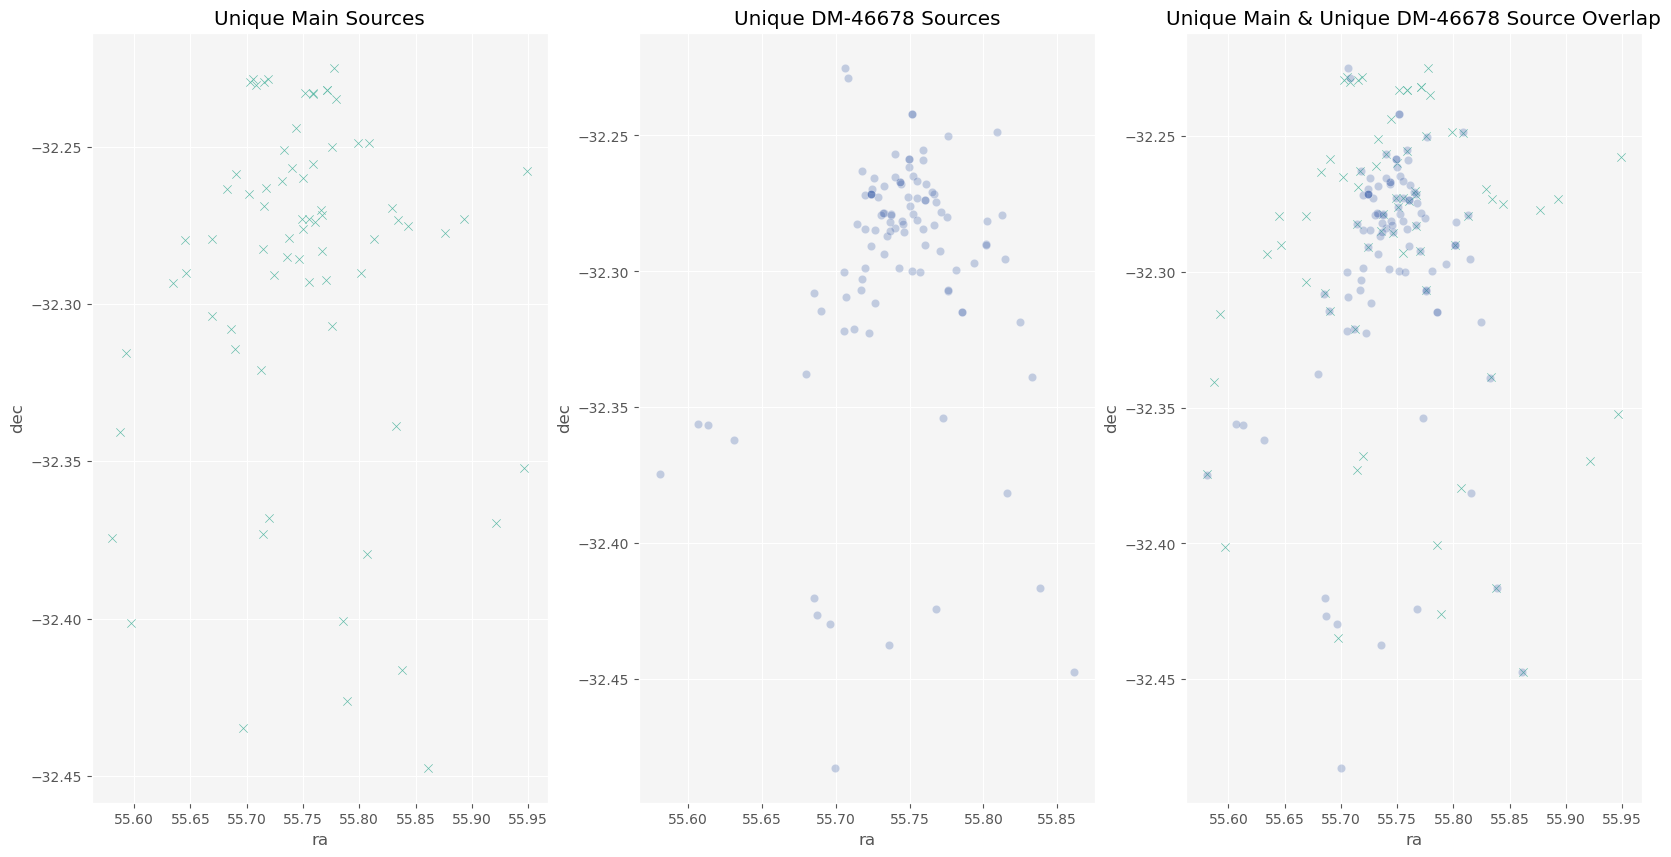

In [14]:
# Unique sources from Main and DM-46678
f, axes = plt.subplots(1, 3, figsize=(20,10))
sns.scatterplot(data=uniqueMain, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[16], alpha=1.0, ax=axes[0]).set(title=f'Unique Main Sources');
sns.scatterplot(data=uniqueUpdated, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[19], alpha=0.3, ax=axes[1]).set(title=f'Unique DM-46678 Sources');
sns.scatterplot(data=uniqueMain, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[16], alpha=1.0, ax=axes[2]).set(title=f'Unique Main & Unique DM-46678 Source Overlap');
sns.scatterplot(data=uniqueUpdated, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[19], alpha=0.3, ax=axes[2]);


### 5. Source Comparison at Detector-Level

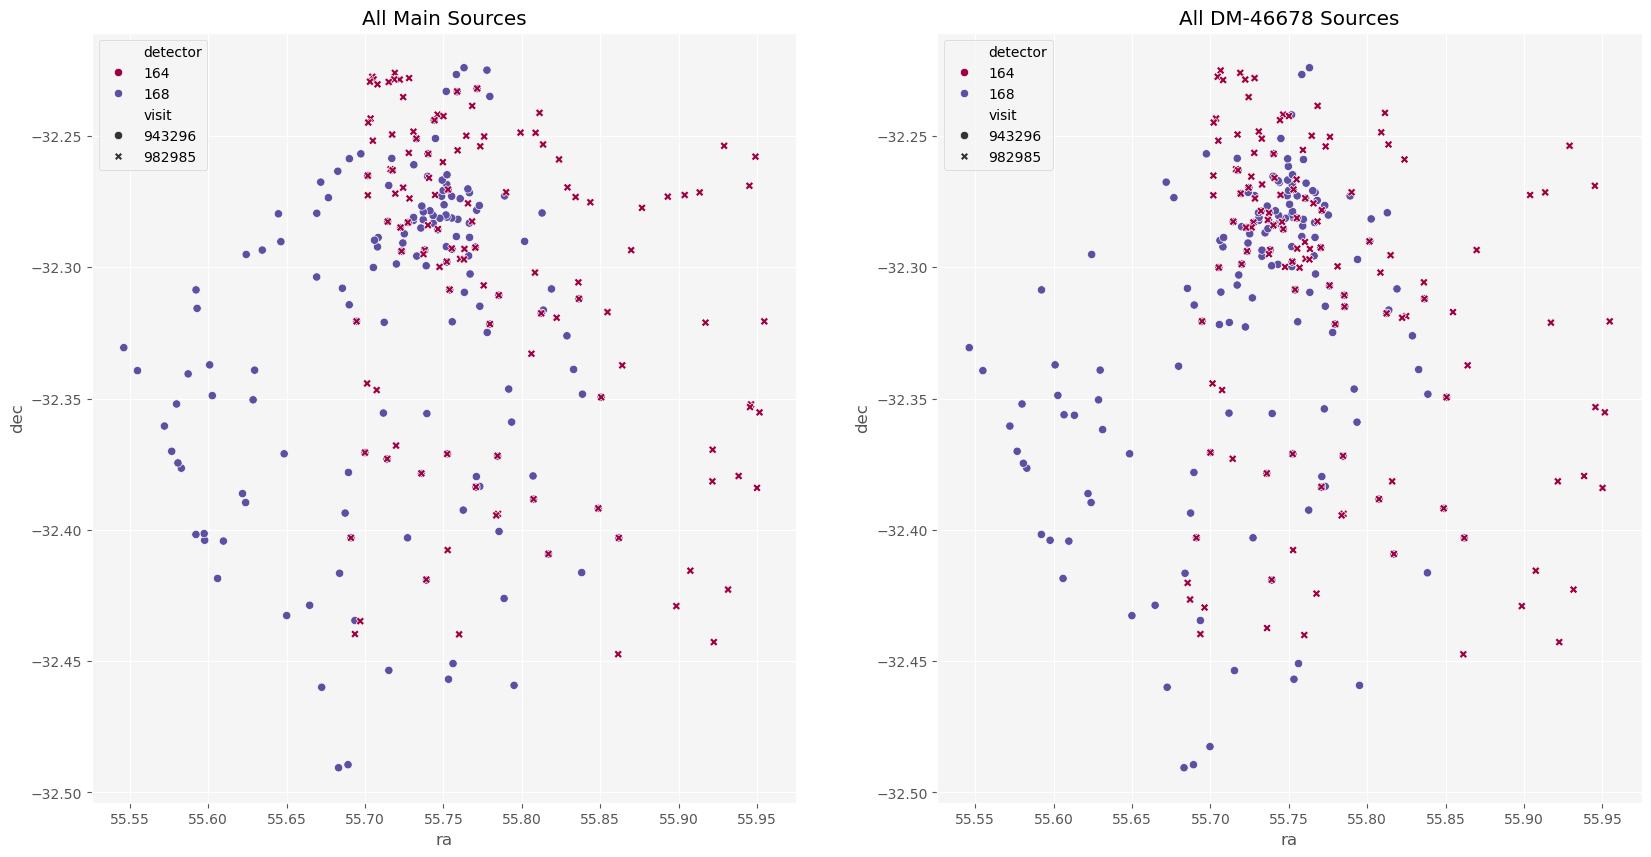

In [15]:
f, axes = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=main_run['rsrcTable'], x='ra', y='dec', hue='detector', style='visit', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[0]).set(title=f'All Main Sources');
sns.scatterplot(data=updated_run['rsrcTable'], x='ra', y='dec', hue='detector', style='visit', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[1]).set(title=f'All DM-46678 Sources');

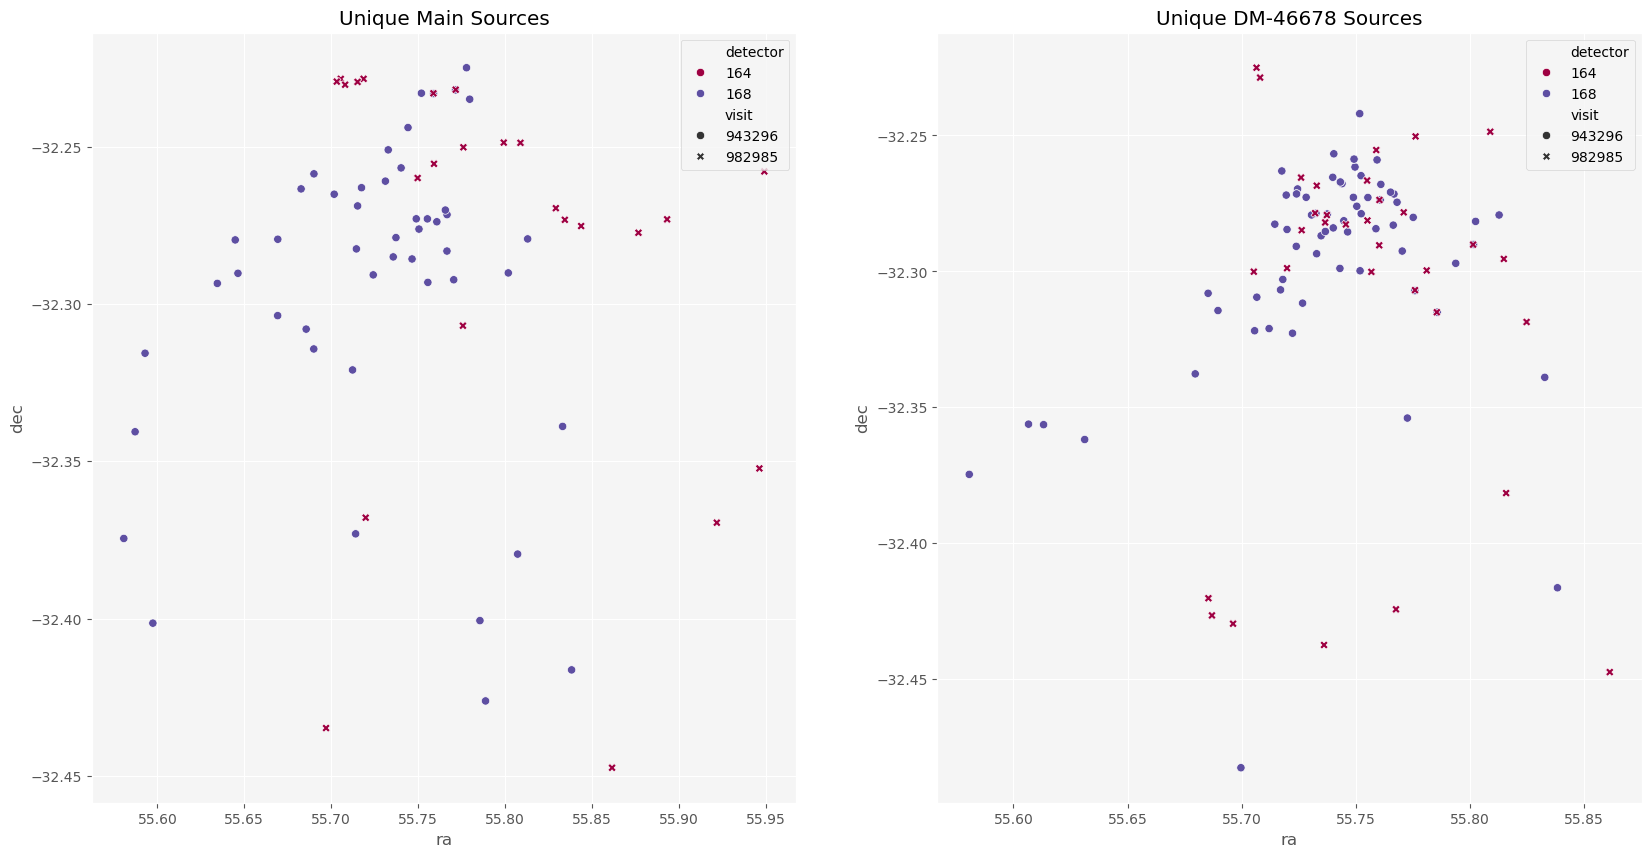

In [16]:
f, axes = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=uniqueMain, x='ra', y='dec', hue='detector', style='visit', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[0]).set(title=f'Unique Main Sources');
sns.scatterplot(data=uniqueUpdated, x='ra', y='dec', hue='detector', style='visit', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[1]).set(title=f'Unique DM-46678 Sources');

In [17]:
def sourceCompByDetector(main, comparison, mainTitle, updatedTitle):
    for v, d in zip(visitsAndDetectors['visits'], visitsAndDetectors['detectors']):
        f, axes = plt.subplots(1, 3, figsize=(20,10))
        constrainedMain = main[(main['visit'] == v) & (main['detector'] == d)]
        constrainedUpdated = comparison[(comparison['visit'] == v) & (comparison['detector'] == d)]
        sns.scatterplot(data=constrainedMain, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[1], alpha=1.0, ax=axes[0]).set(title=f'{mainTitle} ({len(constrainedMain)}):\nVisit {v}, Detector {d}');
        sns.scatterplot(data=constrainedUpdated, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[4], alpha=0.3, ax=axes[1]).set(title=f'{updatedTitle} ({len(constrainedUpdated)}):\nVisit {v}, Detector {d}');
        sns.scatterplot(data=constrainedMain, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[1], alpha=1.0, ax=axes[2]).set(title=f'Overlapping {mainTitle} ({len(constrainedMain)}) & {updatedTitle} ({len(constrainedUpdated)}):\nVisit {v}, Detector {d}\n{updatedTitle}/{mainTitle} Ratio: {len(constrainedUpdated)/len(constrainedMain):.2f}');
        sns.scatterplot(data=constrainedUpdated, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[4], alpha=0.3, ax=axes[2]);

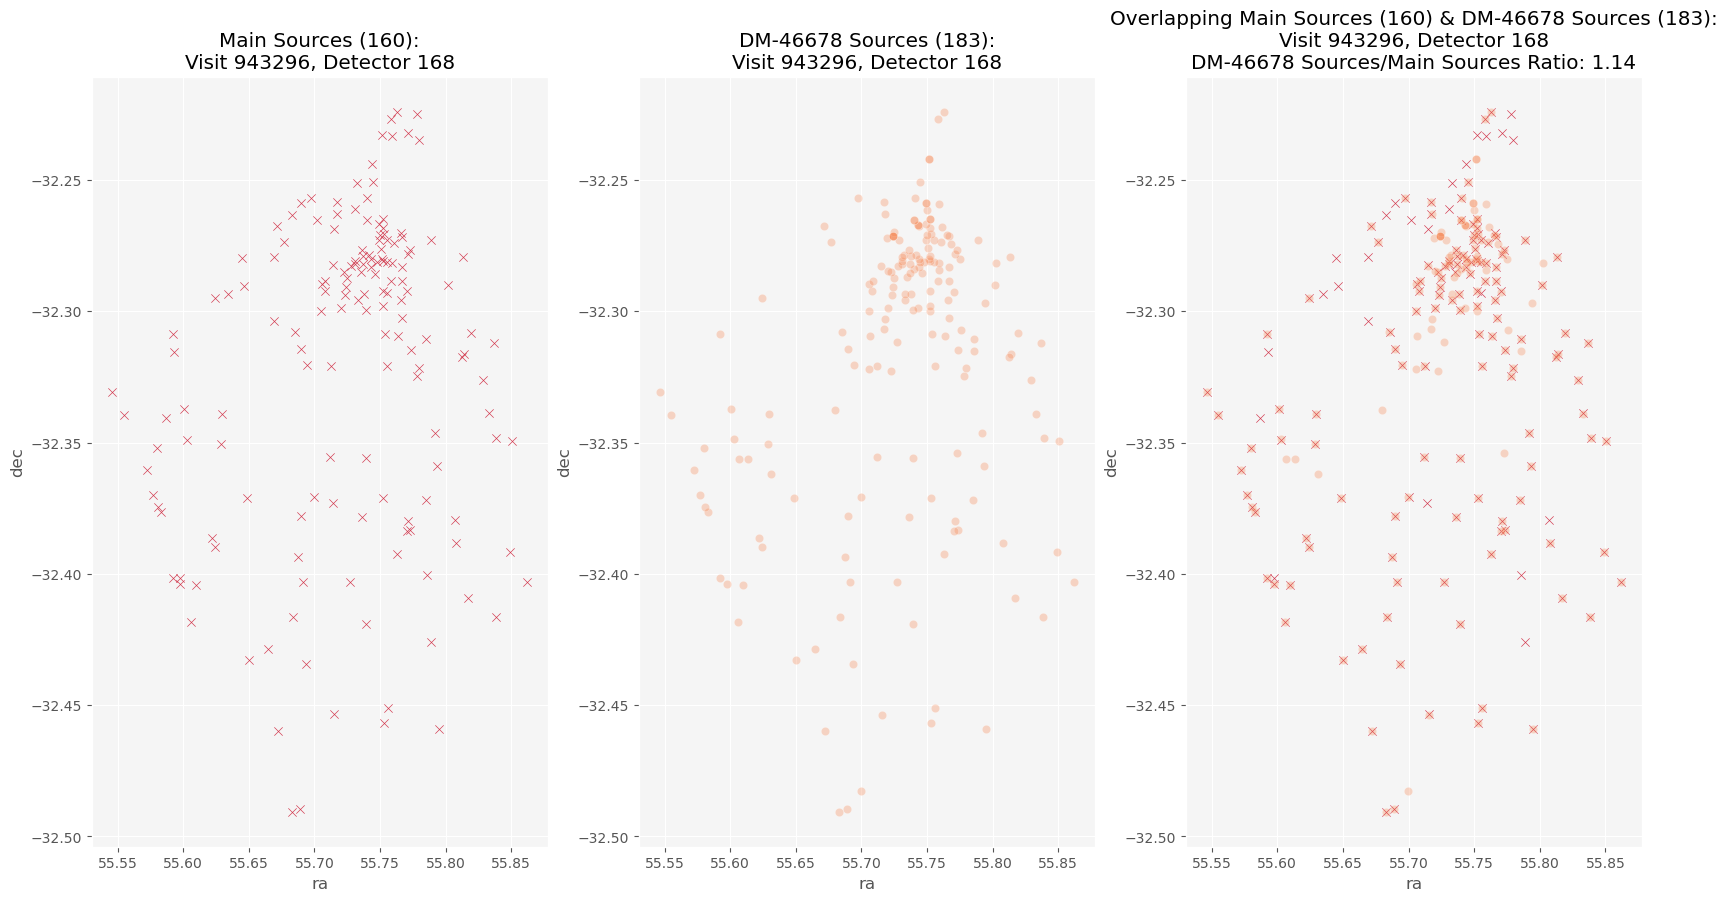

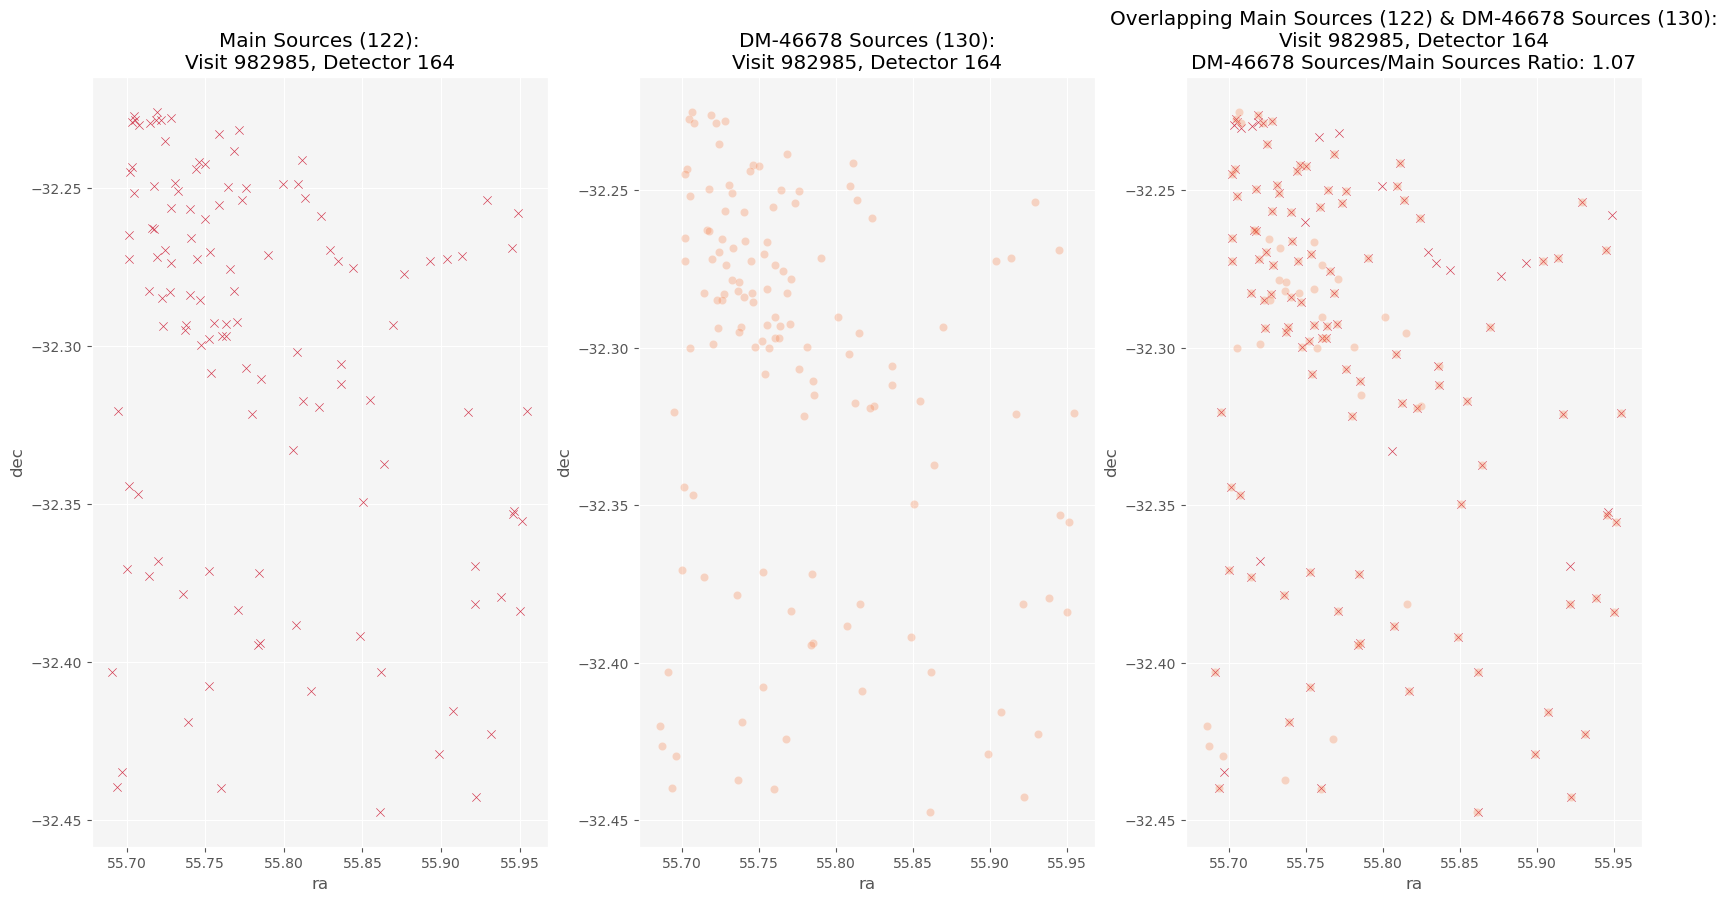

In [18]:
sourceCompByDetector(main_run['rsrcTable'], updated_run['rsrcTable'], 'Main Sources', 'DM-46678 Sources')